In [1]:
!pip install fastai torch torchvision


In [3]:
from fastai.vision.all import *
from torchvision.models import resnet34
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T

# Path to your dataset
data_path = Path(r'C:\Users\DELL\Desktop\endangered specie\Danger Of Extinction')

# Data preparation
def get_dls(bs=64, size=128):
    transform = T.Compose([
        T.Resize(size),
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    dataset = ImageFolder(data_path, transform=transform)
    dls = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=4)
    return dls

dls = get_dls()

# Simple GAN architecture
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Initialize models
nz = 100  # Size of z latent vector (i.e. size of generator input)
netG = Generator(nz).cuda()
netD = Discriminator().cuda()

# Loss function and optimizer
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
epochs = 50
real_label = 1
fake_label = 0

for epoch in range(epochs):
    for i, data in enumerate(dls):
        # Update Discriminator
        netD.zero_grad()
        real_images = data[0].cuda()
        b_size = real_images.size(0)
        labels = torch.full((b_size,), real_label, dtype=torch.float, device='cuda')
        output = netD(real_images).view(-1)
        errD_real = criterion(output, labels)
        errD_real.backward()
        
        noise = torch.randn(b_size, nz, 1, 1, device='cuda')
        fake_images = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        labels.fill_(real_label)
        output = netD(fake_images).view(-1)
        errG = criterion(output, labels)
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{epochs}][{i}/{len(dls)}] Loss_D: {errD_real + errD_fake:.4f} Loss_G: {errG:.4f}')

# Save the generator model
torch.save(netG.state_dict(), 'generator.pth')


ValueError: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([1600])) is deprecated. Please ensure they have the same size.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(999)

# Hyperparameters
batch_size = 64
nz = 256  # Size of z latent vector (input to generator)
lr = 0.0002  # Learning rate
beta1 = 0.5  # Beta1 hyperparam for Adam optimizers
num_epochs = 100  # Number of epochs

# Data preparation
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=r'C:\Users\DELL\Desktop\endangered specie\Danger Of Extinction', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Initialize models
netG = Generator(nz).cuda()
netD = Discriminator().cuda()

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_images = data[0].cuda()
        b_size = real_images.size(0)
        labels = torch.full((b_size,), 1, dtype=torch.float, device='cuda')
        output = netD(real_images).view(-1)
        errD_real = criterion(output, labels)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device='cuda')
        fake_images = netG(noise)
        labels.fill_(0)
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        labels.fill_(1)
        output = netD(fake_images).view(-1)
        errG = criterion(output, labels)
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD_real + errD_fake:.4f} Loss_G: {errG:.4f}')

# Save the generator model
torch.save(netG.state_dict(), 'generator.pth')


[0/100][0/125] Loss_D: 1.3565 Loss_G: 2.6863
[0/100][50/125] Loss_D: 0.1589 Loss_G: 4.9163
[0/100][100/125] Loss_D: 0.6701 Loss_G: 2.5292
[1/100][0/125] Loss_D: 0.6004 Loss_G: 2.6410
[1/100][50/125] Loss_D: 0.6402 Loss_G: 5.0651
[1/100][100/125] Loss_D: 1.6084 Loss_G: 7.7183
[2/100][0/125] Loss_D: 0.2420 Loss_G: 3.2454
[2/100][50/125] Loss_D: 0.2205 Loss_G: 3.7883
[2/100][100/125] Loss_D: 0.6309 Loss_G: 5.0686
[3/100][0/125] Loss_D: 0.5871 Loss_G: 4.1075
[3/100][50/125] Loss_D: 0.3199 Loss_G: 4.0084
[3/100][100/125] Loss_D: 0.5132 Loss_G: 4.1331
[4/100][0/125] Loss_D: 0.7431 Loss_G: 6.7323
[4/100][50/125] Loss_D: 0.4079 Loss_G: 3.0608
[4/100][100/125] Loss_D: 0.9200 Loss_G: 2.4895
[5/100][0/125] Loss_D: 0.5315 Loss_G: 2.6828
[5/100][50/125] Loss_D: 0.5133 Loss_G: 4.3724
[5/100][100/125] Loss_D: 0.6348 Loss_G: 6.3940
[6/100][0/125] Loss_D: 0.3856 Loss_G: 3.5409
[6/100][50/125] Loss_D: 0.5038 Loss_G: 4.1508
[6/100][100/125] Loss_D: 0.7507 Loss_G: 5.2254
[7/100][0/125] Loss_D: 0.3783 Loss

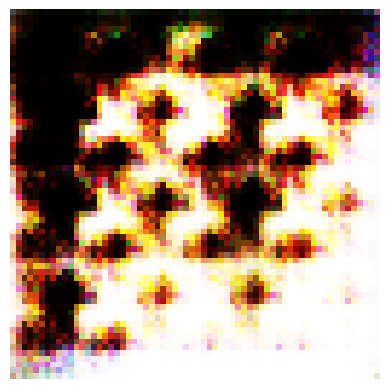

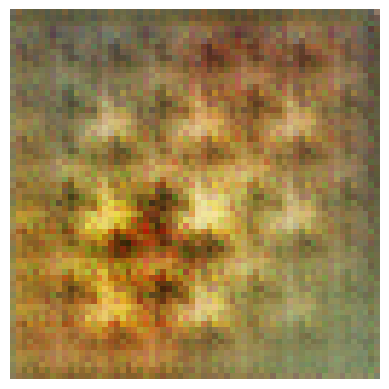

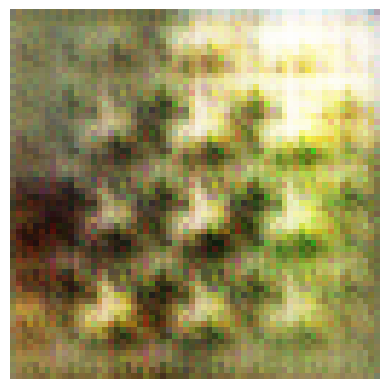

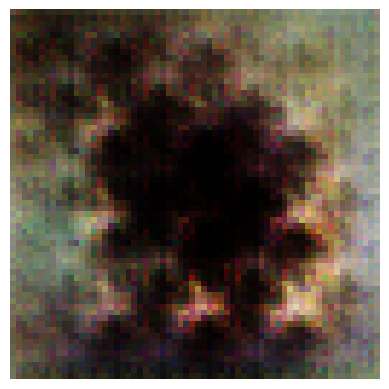

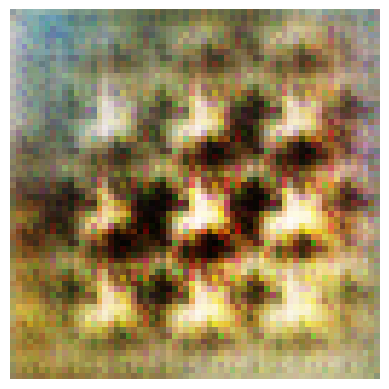

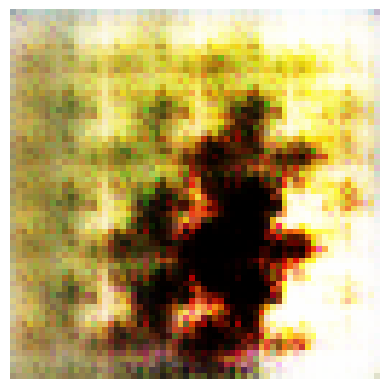

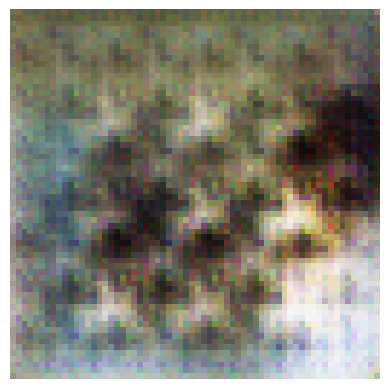

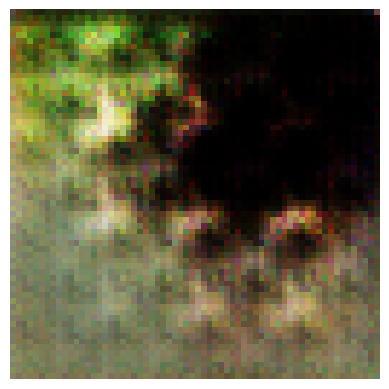

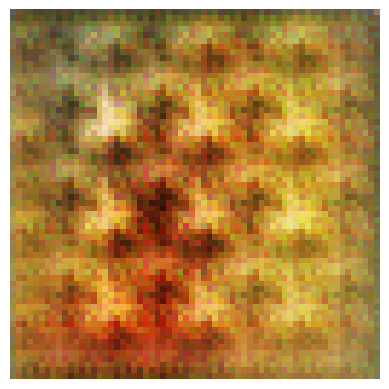

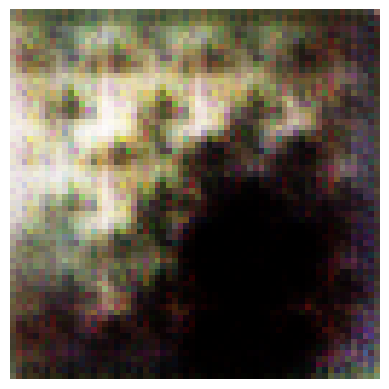

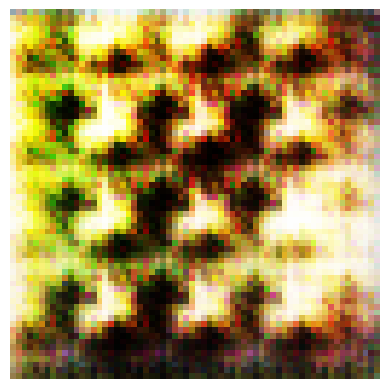

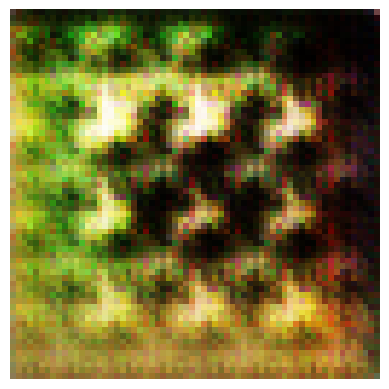

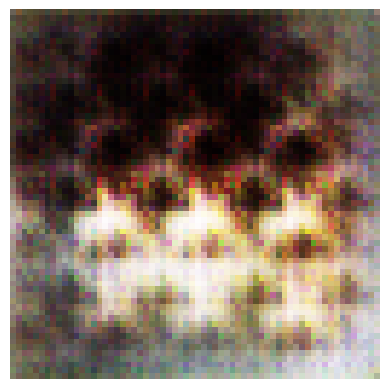

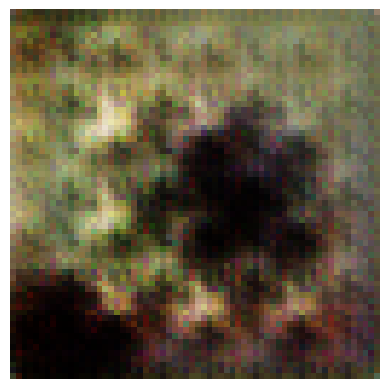

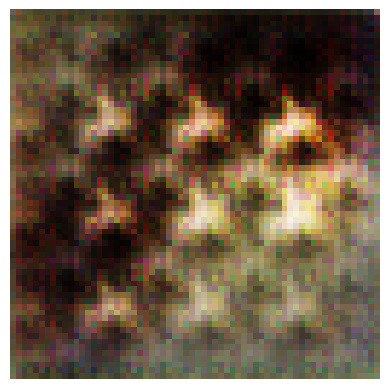

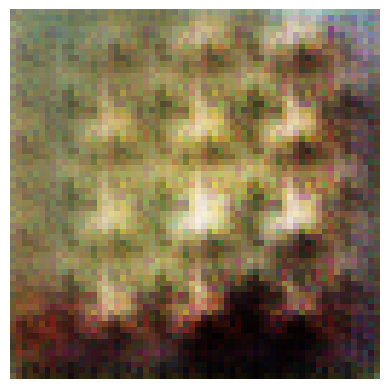

In [5]:
import torch
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Define the Generator class (same as above)
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Load the trained Generator model
nz = 100  # Size of z latent vector (input to generator)
netG = Generator(nz).cuda()
netG.load_state_dict(torch.load('generator.pth'))
netG.eval()

# Function to generate and save images
def generate_and_save_images(num_images=16, z_dim=100):
    noise = torch.randn(num_images, z_dim, 1, 1, device='cuda')
    with torch.no_grad():
        fake_images = netG(noise).cpu()
    for i in range(num_images):
        save_image(fake_images[i], f'generated_image_{i}.png')
        plt.imshow(fake_images[i].permute(1, 2, 0) * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

# Generate and visualize images
generate_and_save_images()


In [6]:
nz = 256  # Increase the latent vector size


In [7]:
num_epochs = 100  # Increase the number of epochs
